In [1]:
from astropy.io import fits

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


This example notebook demonstrates how `pyTWR` radial modification of Tremaine-Weinderg method, introduced in https://arxiv.org/pdf/astro-ph/0511069.pdf, should be applied to real data.

In [2]:
import pytwr

# Data preparation

We will use the same CO data for **NGC 1068** from BIMA SONG survey https://ned.ipac.caltech.edu/level5/March02/SONG/SONG.html, as in the original paper.

We need FITS files for TWR: velocities map (moment 1) and surface densities (or intensities as equivalent, moment 0).

For correct estimation we also need to find in literature of measure information about positional angle (`PA`), distance to galaxy (`D`), size of pix in data in arcsec (`bima_scale`), galaxy center location on image and systemic velocity if moment 1 map not corrected for it. Additionally we also need to know inclination (`incl`) of the galaxy under consideration.

In [3]:
D = 14.4 # Mpc, thus dist_scale = 0.06814287215328414 kpc/arcsec

bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*0.06814287215328414 # kpc/pix

PA = 270. # deg

image_center = (177.5, 171.5) # image center in pix

incl = 40. # deg

v_syst = 1136. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

Load data and take a look at it:

In [4]:
fname = '../spirals/fourier-spiral-masks/data/recurrent_cr/NGC1068.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.

fname = '../spirals/fourier-spiral-masks/data/recurrent_cr/NGC1068.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


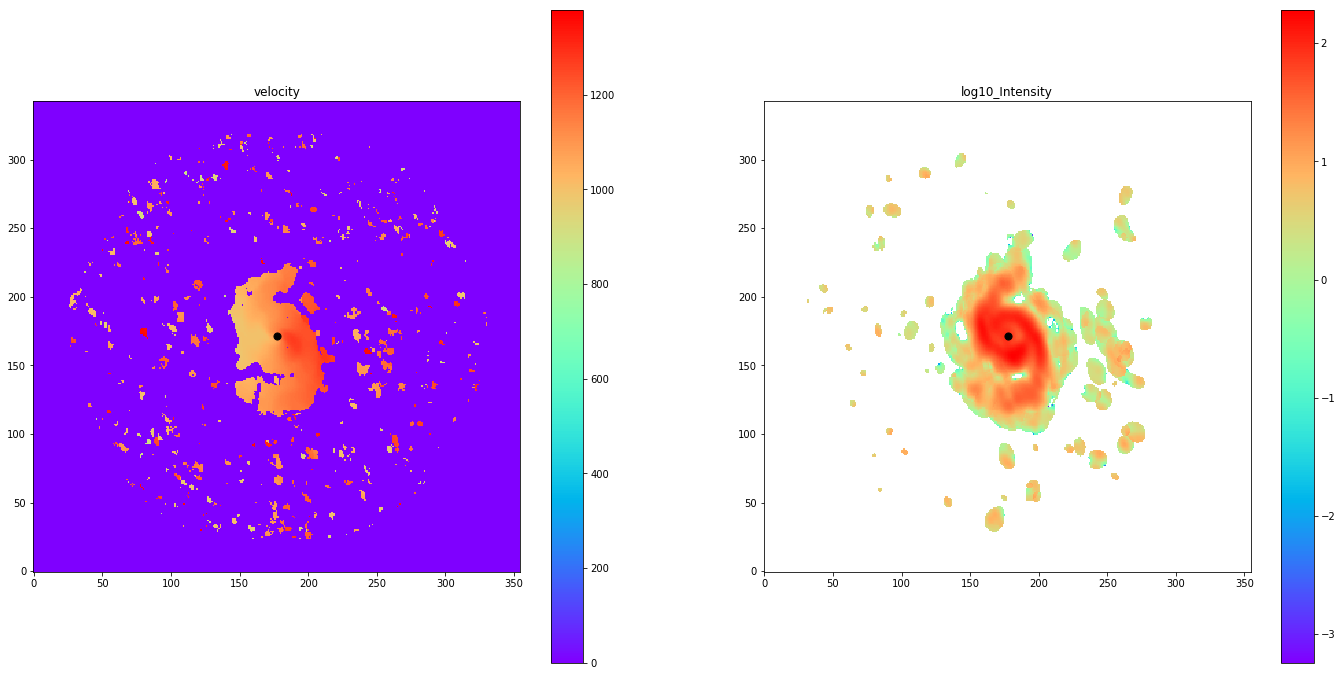

In [5]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()

Let's rotate both maps thus so major axis align parallel to X-axis. *Note that you sometimes you need to use 90+PA instead of PA, just keep an eye on resulted image.*

In [6]:
plane_v = pytwr.rotate_image(mom1data, angle=270.+90., center=image_center)
plane_intens = pytwr.rotate_image(mom0data, angle=270.+90., center=image_center)

Subtract systemic velocity:

In [7]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


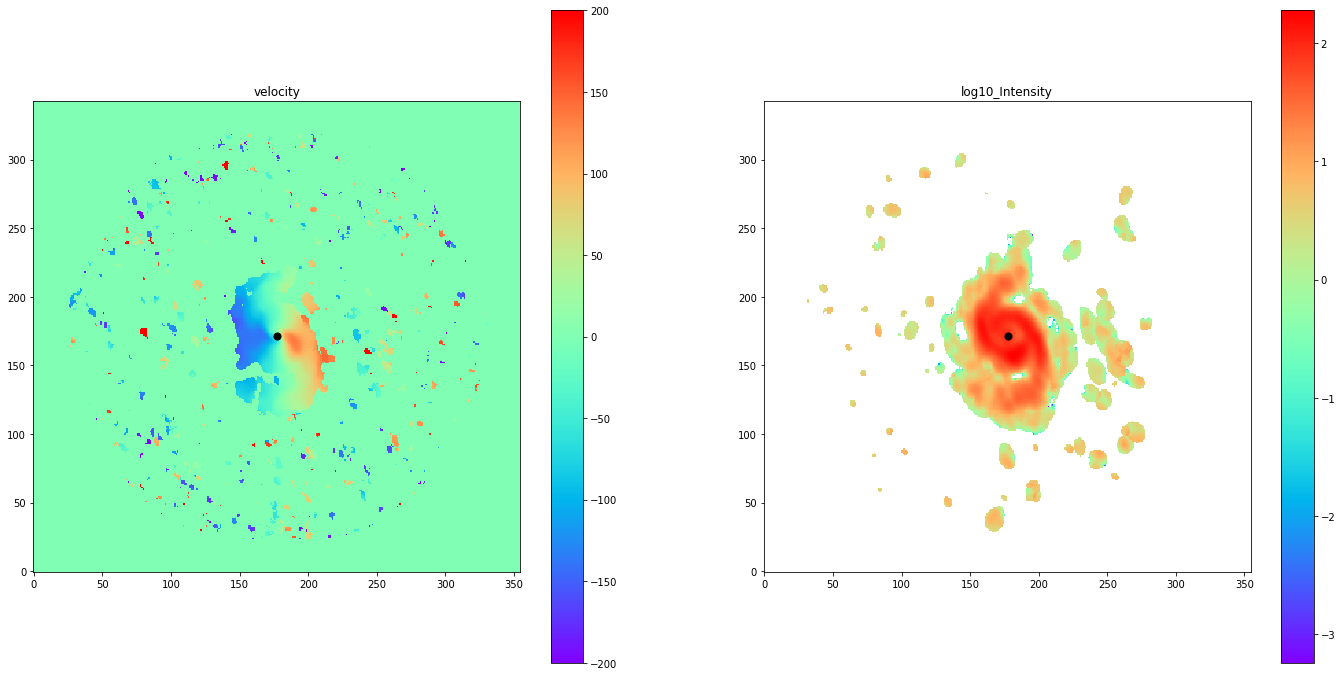

In [8]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()

Make sure that velocities on Y-axis are close to zero, which mean the PA rotation and systemic velocity are correct.

Data is ready now for pattern velocity search.

# Application of TWR

To find pattern speeds we need to select side of the galaxy we will use (y>0 or y<0) and solve Eq. (3) from https://arxiv.org/pdf/0711.4104.pdf numerically. To do so, we need to cut galaxy to ellipses (see Fig. 1 in the same page), choose limits of integration `X_lim` and solve triangular matrix equation.

How we cut to ellipses is an essential part, because this determines on which radii we will detect pattern speed $\Omega$ (and its variations). Usually it is natural to have cuts of the same width, so we need to choose `ymin` - offset from the galaxy's center in pix (or, in other words, where we start the first ellipse. This is needed if you want to avoid bar, etc.), `delta_y` - step between cuts and number of cuts `y_bins`. 

Let's illustrate this for y>0 side:

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


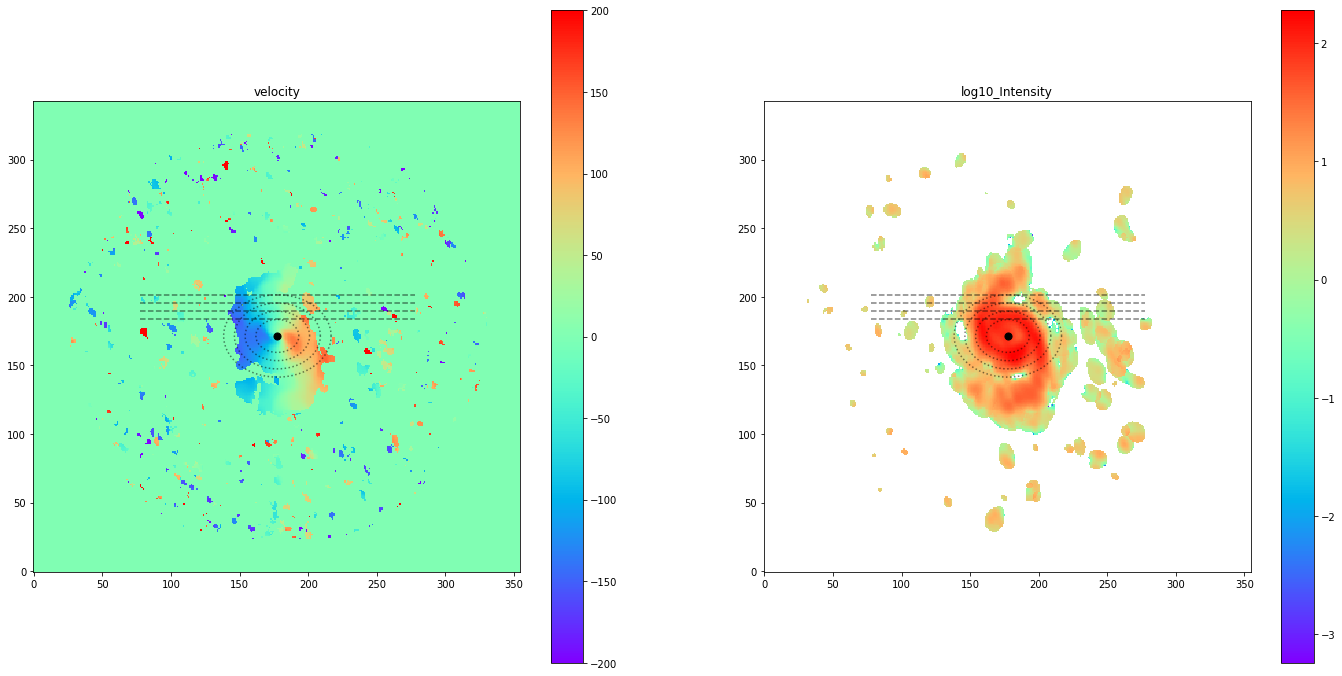

In [9]:
ymin = 12.
y_bins = 3
delta_y = 6.
X_max = 100.
            
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

pytwr.add_ells(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

pytwr.add_ells(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

plt.show()

There are 3 radial bins, because the inner one is just offset and not included. Let's show how TWR can be applied for exactly the same set of parameters:

In [10]:
%%time
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=False, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

CPU times: user 1min 9s, sys: 12.7 s, total: 1min 22s
Wall time: 1min 3s


Besides already known parameters there are three additional:

* `verbose` constrols if you want to see additional prints and pictures for better understanding and debugging (example below)
* `r_scale` is just a scale in kpc/pix to convert $\Omega$ to proper units
* `lim_frame` works for `verbose=True` only and regulate if we see the full image or just part of it

Returned values are list of pattern speeds in km/s/kpc and radial bins in pix:

In [11]:
omega, rrs

(array([363.50125925, 158.91716586, 104.18695274]),
 [15.664887471987344,
  23.497331207981016,
  31.329774943974687,
  39.16221867996836])

Let's plot them:

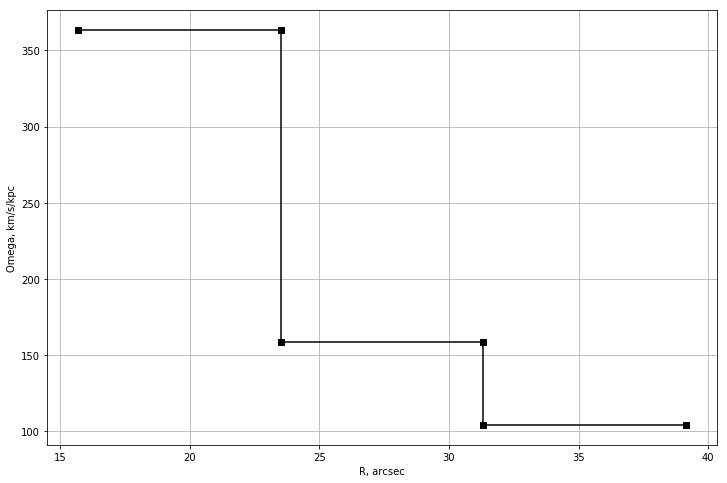

In [12]:
fig = plt.figure(figsize=[12,8])
ax = plt.gca()
tmp = []
for ind, om in enumerate(omega):
    tmp.append([rrs[ind]*bima_scale, om])
    tmp.append([rrs[ind+1]*bima_scale, om])
tmp = np.array(tmp)
ax.plot(tmp[:, 0], tmp[:, 1], '-s', color='k')
ax.grid()
plt.xlabel('R, arcsec')
plt.ylabel('Omega, km/s/kpc')
plt.show()

Thus we can conclude that for such parameters $\Omega$ is not constant and vary in the disk.

Let's run the same TWR with `verbose=True`:

/mnt/sdb2/science/pyTWR/pytwr.py:134: RuntimeWarning: divide by zero encountered in log2
  im = plt.imshow(np.squeeze(np.log2(intens)), origin='lower', cmap='rainbow')
/mnt/sdb2/science/pyTWR/pytwr.py:134: RuntimeWarning: invalid value encountered in log2
  im = plt.imshow(np.squeeze(np.log2(intens)), origin='lower', cmap='rainbow')


radial bins: [15.664887471987344, 23.497331207981016, 31.329774943974687, 39.16221867996836]

K:
  [[-113.68535911 -945.15502836 -152.32209083]
 [   0.         -701.67707596 -285.24822895]
 [   0.            0.         -496.74121641]]
b:
  [-207396.10408267 -141227.67601081  -51753.95363744]
Omega: [363.50125925 158.91716586 104.18695274]
Residuals: [0. 0. 0.]


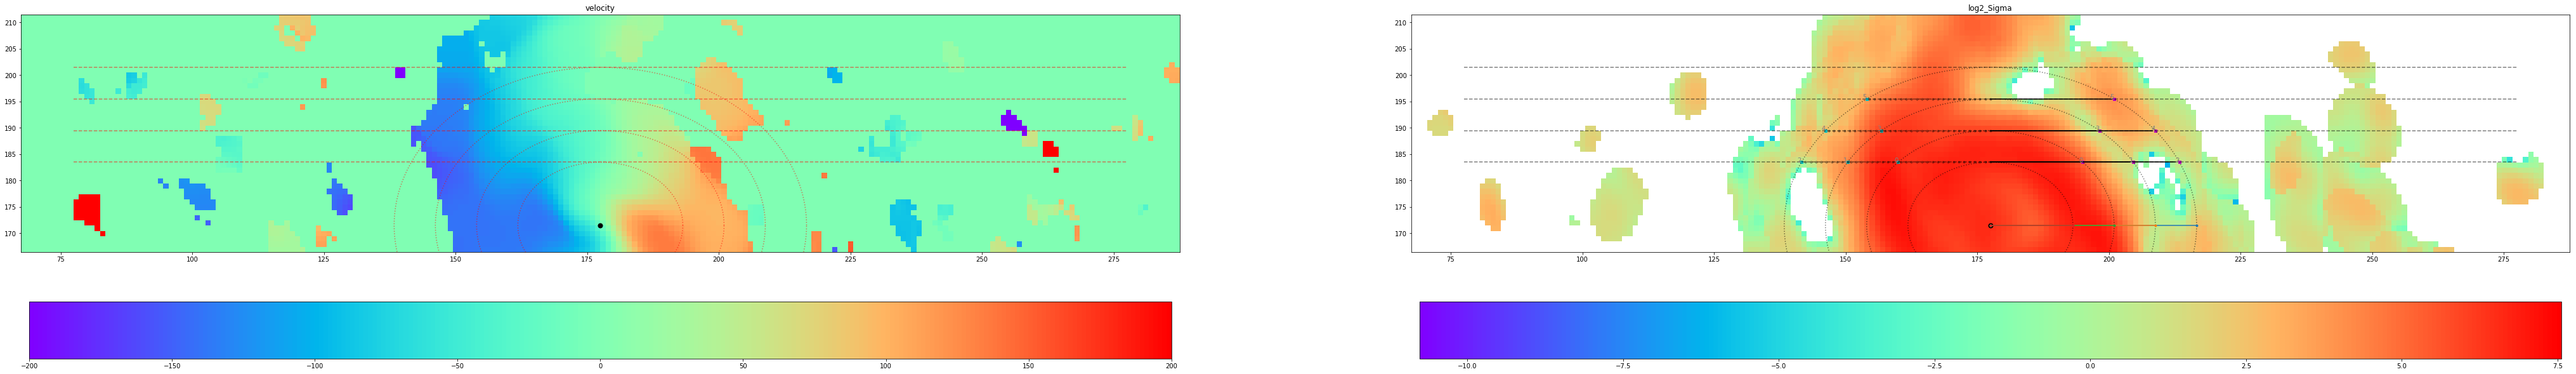

In [13]:
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=True, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

We now see additional information, including matrix, right side of the equation, residuals of solution and two additional plots, which shows location of ellipses and integration limits.

Let's reproduce results from original paper in 2006 for NGC1068, this Fig:

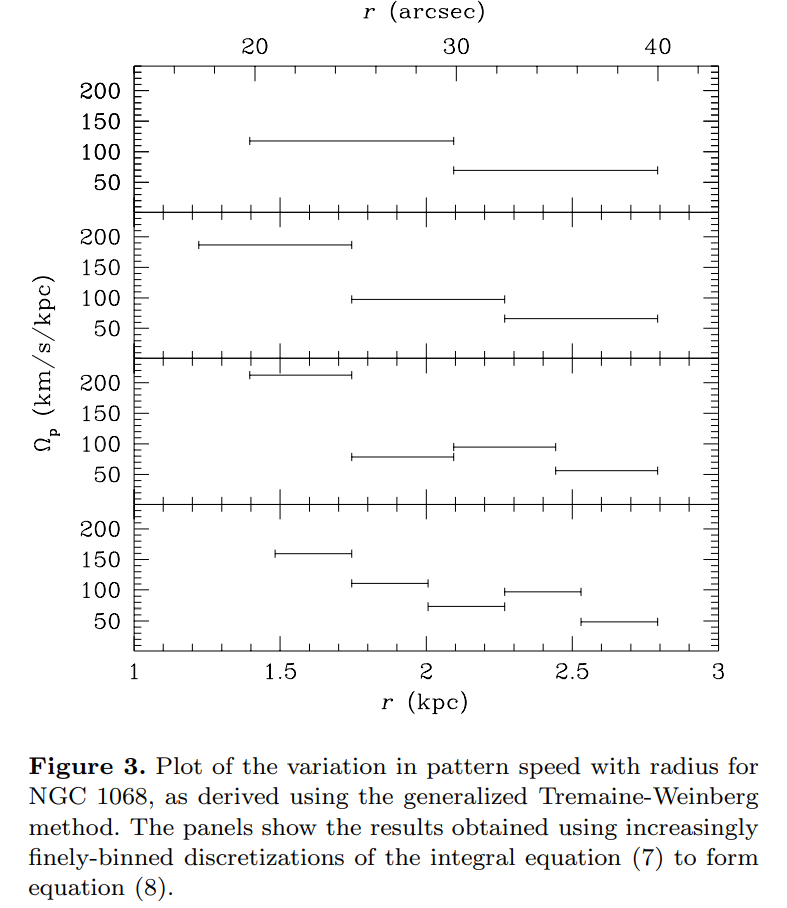

In [15]:
from IPython.display import Image
Image('pics/twr_2006_n1068.png')

In [16]:
# copy points approximately to dictionary
m06_1068 = [(array([20.95743589, 24.73836799, 24.73585366, 28.51687555, 28.5149    ,
         32.2959219 , 32.34827396, 36.12929586, 36.12669172, 39.95871872]),
  array([160.28119508, 158.5940246 , 111.35325132, 111.35325132,
          74.23550088,  74.23550088,  97.85588752,  97.85588752,
          48.92794376,  47.24077329])),
 (array([19.69568843, 24.75390299, 24.74689877, 29.80529293, 29.80610111,
         34.86449527, 34.86251972, 39.97191898]),
  array([213.84885764, 210.4745167 ,  78.87521968,  78.87521968,
          94.05975395,  94.05975395,  56.94200351,  55.25483304])),
 (array([17.2034431 , 24.71430221, 24.76063782, 32.37377651, 32.37207035,
         39.93402435]),
  array([188.11950791, 186.43233743,  97.01230228,  97.01230228,
          64.95606327,  63.26889279])),
 (array([19.71598271, 29.83286083, 29.83025669, 39.9981399 ]),
  array([115.14938489, 116.83655536,  67.9086116 ,  67.9086116 ]))]

One not obvious part - which `X_lim` to use. Let's take as big as possible.

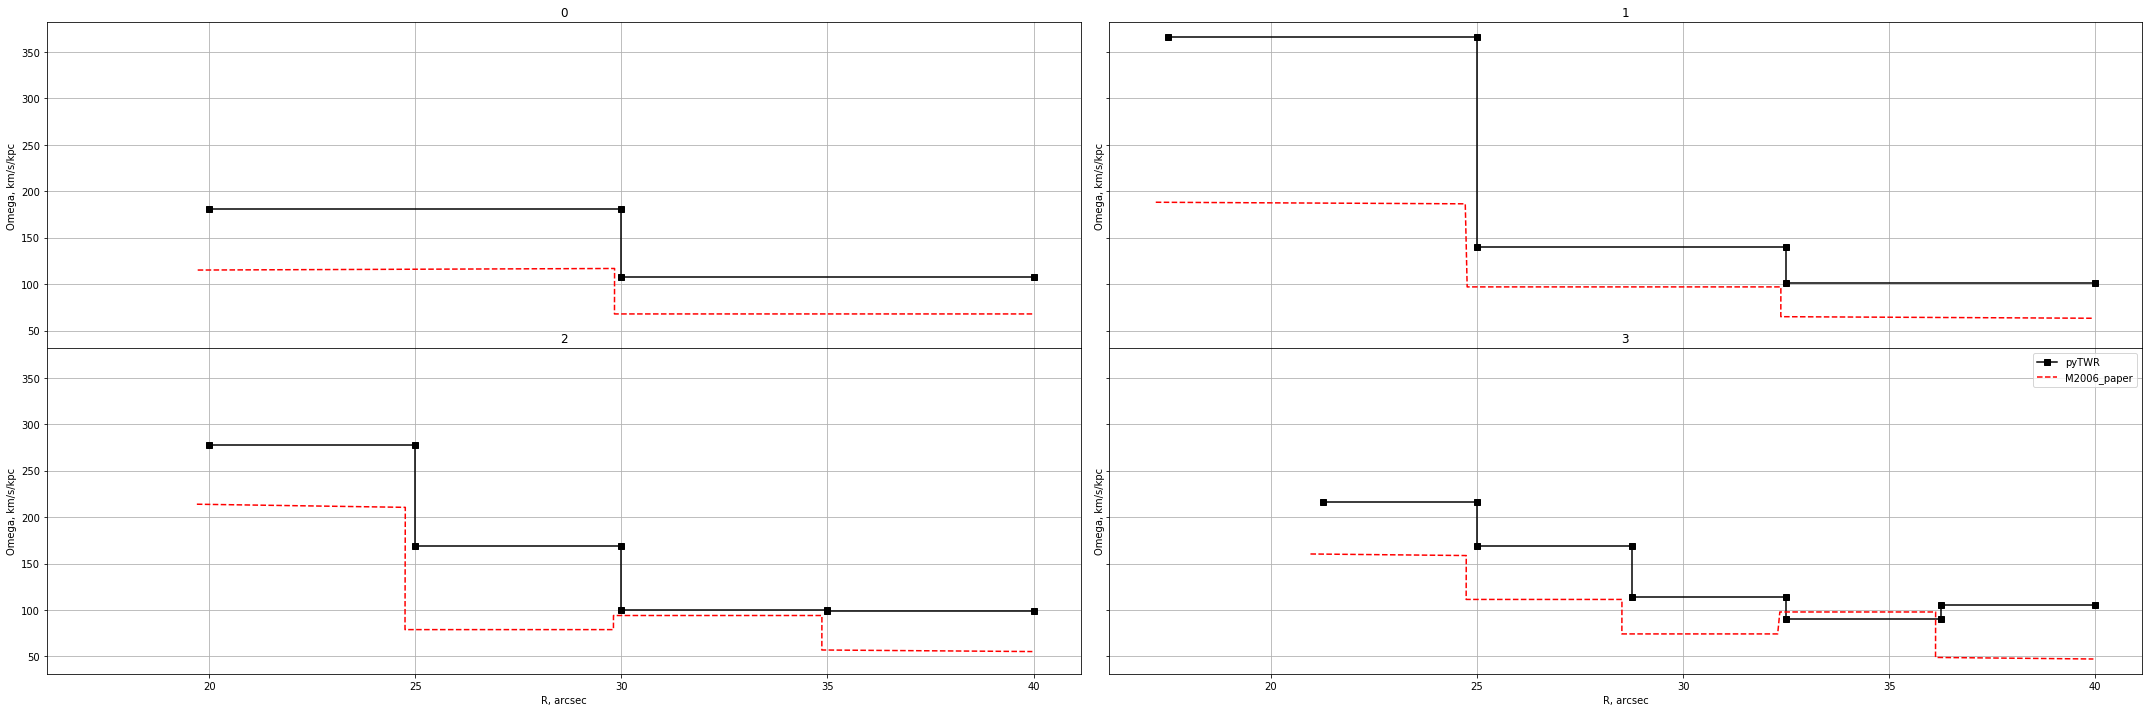

In [17]:
# %%time
xxlim=148.

fig, axes = plt.subplots(figsize=[30, 10], ncols=2, nrows=2, sharex=True, sharey=True)


axes = np.ravel(axes)
bin_sizes = {0 : 10., 1 : 7.5, 2 : 5., 3 : 3.75}
m06_map = {0 : 3, 1 : 2, 2 : 1, 3 : 0}

for ind in range(4):
    bs = bin_sizes[ind]
    cos_i = np.cos(incl * np.pi / 180.)
    omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                           center=image_center, incl=incl,
                           delta_y = bs*cos_i, y_bins = ind+2, X_max = xxlim, ymin=40.*cos_i-bs*(ind+2)*cos_i, verbose=False, r_scale=pix_kpc)
    ax = axes[ind]
    tmp = []
    for ind_, om in enumerate(omega):
        tmp.append([rrs[ind_]*bima_scale, om])
        tmp.append([rrs[ind_+1]*bima_scale, om])
    tmp = np.array(tmp)
    ax.plot(tmp[:, 0], tmp[:, 1], '-s', color='k', label='pyTWR')
    ax.grid()
    ax.plot(m06_1068[m06_map[ind]][0], m06_1068[m06_map[ind]][1], '--', color='r', label='M2006_paper')
    ax.set_xlabel('R, arcsec')
    ax.set_ylabel('Omega, km/s/kpc')
    ax.set_title(ind)

fig.tight_layout()
plt.subplots_adjust(hspace = .001)

plt.legend()
plt.show()